![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Stochastic Gradient Descent (SGD) - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainSGD_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(0)

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/03_OptimizationMethods/SGD_Aux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- What we have so far:
from SGD_Aux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Accuracy

#### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTorchTrainSet.classes
mX       = oTorchTrainSet.data.view(-1,784).numpy() / 255
vY       = oTorchTrainSet.targets.numpy()
mX.shape, vY.shape

((60000, 784), (60000,))

In [7]:
list(zip(range(10), lClasses))

[(0, 'T-shirt/top'),
 (1, 'Trouser'),
 (2, 'Pullover'),
 (3, 'Dress'),
 (4, 'Coat'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

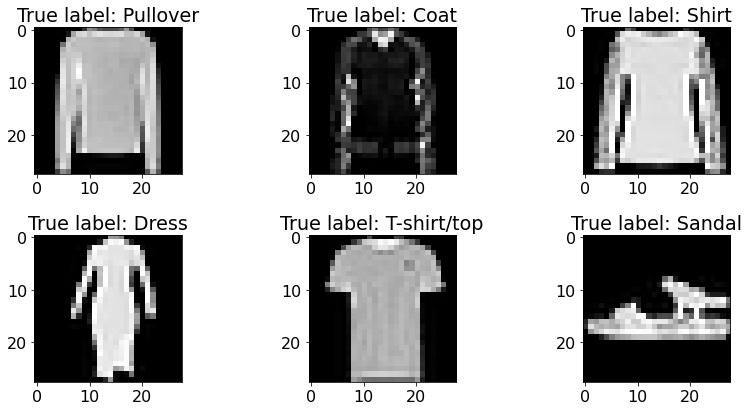

In [8]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(12, 6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [9]:
vMean = mX.mean(0)
vStd  = mX.std (0)
mX    = (mX - vMean) / vStd

####  Split to train and validation:

In [10]:
from sklearn.model_selection import train_test_split

Ntrain = 55000
Nval   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=Ntrain, test_size=Nval)

(
mTrainX.shape, 
vTrainY.shape, 
mValX  .shape,  
vValY  .shape
)

((55000, 784), (55000,), (5000, 784), (5000,))

### Define a dataset (data loader) class:

In [11]:
class Dataset:
    def __init__(self, mX, vY, batchSize):
        self.mX        = mX
        self.vY        = vY
        self.N         = len(vY)
        self.batchSize = min(batchSize, self.N)
        self.nBatches  = self.N // self.batchSize
            
    def __len__(self):
        return self.nBatches
    
    #-- Loop over mini-batches:
    def __iter__(self):
        vIdx = np.random.permutation(self.N)
    
        for ii in range(self.nBatches):
            startIdx  = ii * self.batchSize
            vBatchIdx = vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]

            yield mBatchX, vBatchY

#### A simple test for `dataset`:
Notice that we drop the last (non-full) batch

In [12]:
batchSize = 5
oDataset  = Dataset(mX[:17,:].T, vY[:17], batchSize)
for (mXi, vYi) in oDataset:
    print(f'mXi.shape = {mXi.shape}, vYi.shape = {vYi.shape}')

mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 5), vYi.shape = (5,)


### Constructing train and validation data loaders:

In [13]:
batchSize = 256
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet   = Dataset(mValX.T,   vValY,   batchSize)

### Training loop with mini-batches:

In [14]:
import time

def TrainEpoch(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData, 1):
       
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (stochasitc gradient descnet):
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
        
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= ii
    epochAcc  /= ii
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData, 1):
        
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += loss
        epochAcc  += Accuracy(mZ, vY)
    
    epochLoss /= ii
    epochAcc  /= ii
    
    return epochLoss, epochAcc

### Qeustion:
Why do we use mini-batches in `ValidationLoop` as well?

#### Train model function:

In [15]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, oTrainData, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, oValData)                 #-- validation
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,  end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,  end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',  end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',  end='')
        print(' | epoch time: '     f'{epochTime:3.3f} |'       )

### Train a shallow model (with mini-batches):

In [16]:
oModel = SequentialModel([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 10),
])

nEpochs = 10
lr      = 2e-1

TrainModel(oModel, oTrainSet, oValSet, nEpochs, lr)

Epoch 000: | Train loss: 0.51849 | Val loss: 0.40362 | Train Accuracy: 0.8216 | Val Accuracy: 0.8579 | epoch time: 1.547 |
Epoch 001: | Train loss: 0.36494 | Val loss: 0.35708 | Train Accuracy: 0.8674 | Val Accuracy: 0.8748 | epoch time: 1.679 |
Epoch 002: | Train loss: 0.32335 | Val loss: 0.35068 | Train Accuracy: 0.8826 | Val Accuracy: 0.8775 | epoch time: 1.613 |
Epoch 003: | Train loss: 0.29563 | Val loss: 0.33874 | Train Accuracy: 0.8924 | Val Accuracy: 0.8820 | epoch time: 1.540 |
Epoch 004: | Train loss: 0.27626 | Val loss: 0.36633 | Train Accuracy: 0.8977 | Val Accuracy: 0.8707 | epoch time: 1.478 |
Epoch 005: | Train loss: 0.25853 | Val loss: 0.32339 | Train Accuracy: 0.9061 | Val Accuracy: 0.8884 | epoch time: 1.541 |
Epoch 006: | Train loss: 0.24270 | Val loss: 0.34638 | Train Accuracy: 0.9112 | Val Accuracy: 0.8814 | epoch time: 1.503 |
Epoch 007: | Train loss: 0.22950 | Val loss: 0.32661 | Train Accuracy: 0.9164 | Val Accuracy: 0.8896 | epoch time: 1.517 |
Epoch 008: | Tra

### Apply model to test data:

Test accuracy: 87.01%


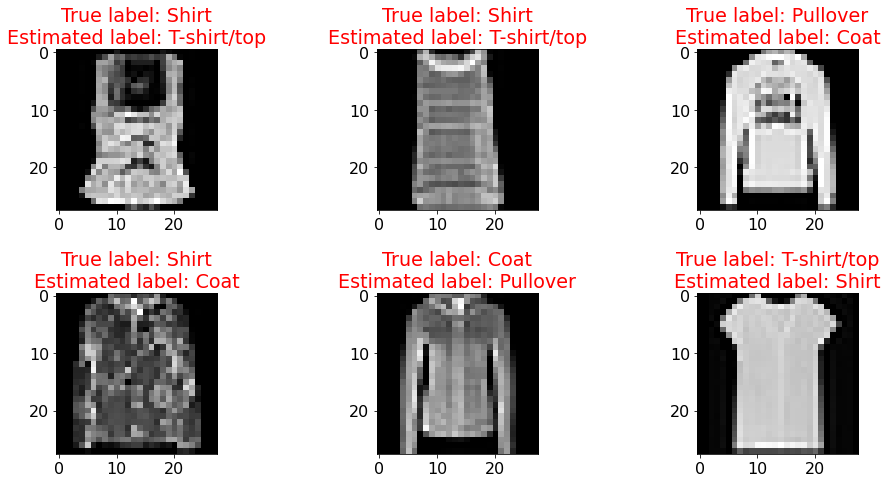

In [17]:
oTorchTestSet = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
mTestX        = oTorchTestSet.data.view(-1,784).numpy() / 255
mTestX        = (mTestX -vMean) / vStd
vTestY        = oTorchTestSet.targets.numpy()

#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
print(f'Test accuracy: {100 * Accuracy(mHatTestY, vTestY)}%')

#-- Plot a few mistakes:
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(14, 7))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow   (np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTestY[idx]]}\nEstimated label: {lClasses[vHatTestY[idx]]}', color='r')
    
plt.tight_layout()
plt.show()

### Exercise
* Add a drop last flag (`bDropLast`):
    * If `bDropLast = False` then the last non-full batch is also returned in the iterations.
* Update `TrainEpoch` and `ValidationEpoch` accordingly

**Extra**: Play with the model (and the hyper-parameters) and improve your validation accuracy.

In [18]:
class Dataset:
    def __init__(self, mX, vY, batchSize, bDropLast=False):
        self.mX        = mX
        self.vY        = vY
        self.N         = len(vY)
        self.batchSize = min(batchSize, self.N)
        self.nBatches  = np.ceil(self.N / self.batchSize).astype(np.int32)
            
    def __len__(self):
        return self.nBatches
    
    #-- Loop over mini-batches:
    def __iter__(self):
        vIdx = np.random.permutation(self.N)
    
        for ii in range(self.nBatches):
            startIdx  = ii * self.batchSize
            vBatchIdx = vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]

            yield mBatchX, vBatchY

#### Test your implementation
You should get $4$ batches, where the last one is not full.

In [19]:
batchSize = 5
oDataset  = Dataset(mX[:17,:].T, vY[:17], batchSize)
for (mXi, vYi) in oDataset:
    print(f'mXi.shape = {mXi.shape}, vYi.shape = {vYi.shape}')

mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 5), vYi.shape = (5,)
mXi.shape = (784, 2), vYi.shape = (2,)


#### Update `TrainEpoch` and `ValidationEpoch`
* Remember that each mini-batch might be of a different size.
* Use `len(vY)` to get the current batch size.

In [20]:
import time

def TrainEpoch(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        
        Nb     = len(vY) #-- currect batch size
        count += Nb
        
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (stochasitc gradient descnet):
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
        
        epochLoss += Nb * loss
        epochAcc  += Nb * Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= count
    epochAcc  /= count
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData):
        
        Nb     = len(vY) #-- currect batch size
        count += Nb
        
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += Nb * loss
        epochAcc  += Nb * Accuracy(mZ, vY)
    
    epochLoss /= count
    epochAcc  /= count
    
    return epochLoss, epochAcc

#### Train model function:

In [21]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, oTrainData, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, oValData)                 #-- validation
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,  end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,  end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',  end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',  end='')
        print(' | epoch time: '     f'{epochTime:3.3f} |'       )

#### Train a shallow model:

In [22]:
oModel = SequentialModel([
        LinearLayer(784, 200),
        ReLULayer(),
        LinearLayer(200, 10),
])

nEpochs = 10
lr      = 2e-1

TrainModel(oModel, oTrainSet, oValSet, nEpochs, lr)

Epoch 000: | Train loss: 0.51956 | Val loss: 0.41189 | Train Accuracy: 0.8173 | Val Accuracy: 0.8592 | epoch time: 1.793 |
Epoch 001: | Train loss: 0.36395 | Val loss: 0.38368 | Train Accuracy: 0.8685 | Val Accuracy: 0.8647 | epoch time: 1.483 |
Epoch 002: | Train loss: 0.32402 | Val loss: 0.34463 | Train Accuracy: 0.8815 | Val Accuracy: 0.8806 | epoch time: 1.483 |
Epoch 003: | Train loss: 0.29588 | Val loss: 0.33989 | Train Accuracy: 0.8910 | Val Accuracy: 0.8826 | epoch time: 1.514 |
Epoch 004: | Train loss: 0.27438 | Val loss: 0.39317 | Train Accuracy: 0.9000 | Val Accuracy: 0.8637 | epoch time: 1.445 |
Epoch 005: | Train loss: 0.25899 | Val loss: 0.32878 | Train Accuracy: 0.9060 | Val Accuracy: 0.8904 | epoch time: 1.482 |
Epoch 006: | Train loss: 0.24418 | Val loss: 0.31886 | Train Accuracy: 0.9116 | Val Accuracy: 0.8917 | epoch time: 1.514 |
Epoch 007: | Train loss: 0.22893 | Val loss: 0.32857 | Train Accuracy: 0.9157 | Val Accuracy: 0.8892 | epoch time: 1.559 |
Epoch 008: | Tra

#### Improve your accuracy:

In [23]:
oModel = SequentialModel([
        LinearLayer(784, 200), ReLULayer(),
        LinearLayer(200, 50 ), ReLULayer(),
        LinearLayer(50,  10 ),
])

nEpochs = 30
lr      = 5e-2

TrainModel(oModel, oTrainSet, oValSet, nEpochs, lr)

Epoch 000: | Train loss: 0.59692 | Val loss: 0.43883 | Train Accuracy: 0.7922 | Val Accuracy: 0.8479 | epoch time: 1.756 |
Epoch 001: | Train loss: 0.40680 | Val loss: 0.40040 | Train Accuracy: 0.8545 | Val Accuracy: 0.8653 | epoch time: 1.630 |
Epoch 002: | Train loss: 0.36391 | Val loss: 0.36925 | Train Accuracy: 0.8707 | Val Accuracy: 0.8721 | epoch time: 1.702 |
Epoch 003: | Train loss: 0.33831 | Val loss: 0.36199 | Train Accuracy: 0.8795 | Val Accuracy: 0.8748 | epoch time: 1.731 |
Epoch 004: | Train loss: 0.31986 | Val loss: 0.34964 | Train Accuracy: 0.8871 | Val Accuracy: 0.8810 | epoch time: 1.665 |
Epoch 005: | Train loss: 0.30437 | Val loss: 0.34282 | Train Accuracy: 0.8915 | Val Accuracy: 0.8808 | epoch time: 1.630 |
Epoch 006: | Train loss: 0.29076 | Val loss: 0.33636 | Train Accuracy: 0.8960 | Val Accuracy: 0.8847 | epoch time: 1.656 |
Epoch 007: | Train loss: 0.27986 | Val loss: 0.32821 | Train Accuracy: 0.8994 | Val Accuracy: 0.8896 | epoch time: 1.658 |
Epoch 008: | Tra

Test accuracy: 88.24%


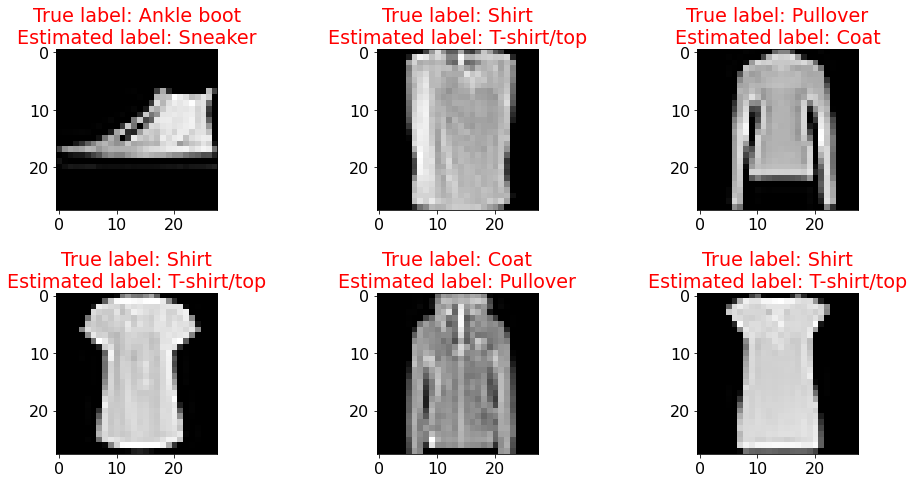

In [24]:
oTorchTestSet = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
mTestX        = oTorchTestSet.data.view(-1,784).numpy() / 255
mTestX        = (mTestX -vMean) / vStd
vTestY        = oTorchTestSet.targets.numpy()

#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
print(f'Test accuracy: {100 * Accuracy(mHatTestY, vTestY)}%')

#-- Plot a few mistakes:
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(14, 7))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow   (np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTestY[idx]]}\nEstimated label: {lClasses[vHatTestY[idx]]}', color='r')
    
plt.tight_layout()
plt.show()